In [1]:
using Revise

ENV["PYCALL_JL_RUNTIME_PYTHON"] = Sys.which("python")
using FileIO
using JLD2
using RiskSensitiveSAC

┌ Info: Number of Julia Thread(s): 1
└ @ RiskSensitiveSAC /home/haruki/Documents/2020-21_Autumn/RiskSensitiveSAC.jl/src/RiskSensitiveSAC.jl:39
┌ Info: CUDA Device: GeForce RTX 2080 Ti
└ @ RiskSensitiveSAC /home/haruki/Documents/2020-21_Autumn/RiskSensitiveSAC.jl/src/RiskSensitiveSAC.jl:40
┌ Info: Python executable used by PyCall: /home/haruki/Documents/2020-21_Autumn/RiskSensitiveSAC.jl/env_trajectron++/bin/python3.6
└ @ RiskSensitiveSAC /home/haruki/Documents/2020-21_Autumn/RiskSensitiveSAC.jl/src/RiskSensitiveSAC.jl:41


# 1. Default

In [11]:
include("$(@__DIR__)/../scripts/default_params/params_data_trajectron.jl");

incl_robot_node = true;
use_robot_future = true;
sim_horizon = 4.4;
prediction_rng_seed = 123;

include("$(@__DIR__)/../scripts/parameter_setup.jl");

In [12]:
scene_loader, controller, w_init, measurement_schedule, target_trajectory, target_speed =
controller_setup(scene_param,
                 predictor_param,
                 prediction_device=prediction_device,
                 cost_param=cost_param,
                 cnt_param=cnt_param,
                 dtc=dtc,
                 sim_horizon=sim_horizon,
                 ado_id_to_replace="PEDESTRIAN/236",
                 verbose=true);

Scene Mode: data
Prediction Mode: trajectron
Deterministic Prediction: false
Loaded evaluation data from /home/haruki/Documents/2020-21_Autumn/RiskSensitiveSAC.jl/Trajectron-plus-plus/experiments/processed/eth_test.pkl
Looking at the eth_test.pkl sequence, data_id 0, start_idx 905
Found PEDESTRIAN/236. start_time_idx updated to: 909 Re-loading Scene...
Loaded evaluation data from /home/haruki/Documents/2020-21_Autumn/RiskSensitiveSAC.jl/Trajectron-plus-plus/experiments/processed/eth_test.pkl
Looking at the eth_test.pkl sequence, data_id 0, start_idx 909
Loaded Trajectron model from /home/haruki/Documents/2020-21_Autumn/RiskSensitiveSAC.jl/Trajectron-plus-plus/experiments/pedestrians/models/models_21_Apr_2020_20_15_41_eth_ar3_rob/model_registrar-100.pt
Note initial time is set to 1.6 [s].


In [13]:
result, controller, ado_positions = 
evaluate(scene_loader, controller, w_init, maximum(target_trajectory)[2],
         target_speed, measurement_schedule, target_trajectory,
         pos_error_replan, nominal_control=false,
         ado_id_removed="PEDESTRIAN/236");

In [14]:
display_log(result.log)

Time 1.60 [sec]: New prediction is available to the controller.
Time 1.60 [sec]: New SAC control computation is scheduled.
Time 1.60 [sec]: New SAC control is available to the controller.
Time 1.60 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 1.62 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 1.64 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 1.66 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 1.68 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 1.70 [sec]: New SAC control computation is scheduled.
Time 1.70 [sec]: Control: [2.0, 0.0] is applied to the system.
Time 1.72 [sec]: New SAC control is available to the controller.
Time 1.72 [sec]: Control: [2.0, 0.0] is applied to the system.
Time 1.74 [sec]: Control: [2.0, 0.0] is applied to the system.
Time 1.76 [sec]: Control: [1.1368266344070435, -4.86904764175415] is applied to the system.
Time 1.78 [sec]: Control: [2.0, 0.0] is applied to the system.
Time 1.80 [sec]: New SAC cont

Time 3.60 [sec]: New SAC control computation is scheduled.
Time 3.60 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 3.62 [sec]: New prediction is available to the controller.
Time 3.62 [sec]: New SAC control is available to the controller.
Time 3.62 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 3.64 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 3.66 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 3.68 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 3.70 [sec]: New SAC control computation is scheduled.
Time 3.70 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 3.72 [sec]: New SAC control is available to the controller.
Time 3.72 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 3.74 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 3.76 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 3.78 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 3.80 [sec]: New SAC control computation is scheduled.

In [15]:
e_state = result.w_history[end].e_state;
w = result.w_history[end];
u_schedule = result.u_schedule_history[end];
target_trajectory = result.target_trajectory_history[end];

In [16]:
rpf = get_robot_present_and_future(e_state, u_schedule, controller.sim_param, controller.cnt_param);

In [17]:
function get_clipped_prediction_dict(prediction_dict::Dict{String, Array{Float64, 3}},
                                     num_samples::Int64,
                                     nominal_control_idx::Int64)
    clipped_preds_dict = Dict{String, Array{Float64, 3}}();
    for key in keys(prediction_dict)
        clipped_array =
            prediction_dict[key][num_samples*(nominal_control_idx - 1) + 1:num_samples*nominal_control_idx, :, :];
        clipped_preds_dict[key] = copy(clipped_array);
    end
    return clipped_preds_dict
end

get_clipped_prediction_dict (generic function with 1 method)

In [18]:
prediction_dict = sample_future_ado_positions!(controller.predictor, ado_positions, rpf);

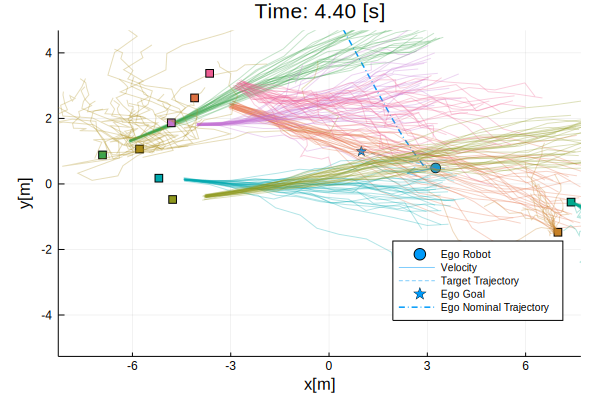

In [19]:
u_nominal_idx = 12;
prediction_dict_clipped = get_clipped_prediction_dict(prediction_dict,
                                              num_samples, u_nominal_idx)
nominal_trajectory = [rpf[u_nominal_idx, t, 1:2] for t = 1:size(rpf, 2)];
plt = visualize!(Dict(), w, target_trajectory, prediction_dict_clipped, num_samples, nominal_trajectory,
         xlim=(-3. + -5.263534, 13. + -5.314636), 
         ylim=(0. + -5.263534, 10. + -5.314636), figsize=(600, 400), 
         legendfontsize=7, legend=:bottomright, markersize=5)

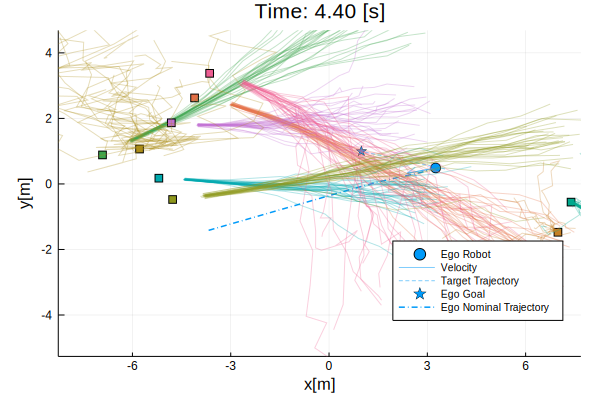

In [20]:
u_nominal_idx = 6;
prediction_dict_clipped = get_clipped_prediction_dict(prediction_dict,
                                              num_samples, u_nominal_idx)
nominal_trajectory = [rpf[u_nominal_idx, t, 1:2] for t = 1:size(rpf, 2)];
plt = visualize!(Dict(), w, target_trajectory, prediction_dict_clipped, num_samples, nominal_trajectory,
         xlim=(-3. + -5.263534, 13. + -5.314636), 
         ylim=(0. + -5.263534, 10. + -5.314636), figsize=(600, 400), 
         legendfontsize=7, legend=:bottomright, markersize=5)

# 2. Deterministic (mode-mode) Prediction

In [21]:
include("$(@__DIR__)/../scripts/default_params/params_data_trajectron.jl");

incl_robot_node = true;
use_robot_future = true;
sim_horizon = 4.4;
num_samples = 1;
deterministic = true;

include("$(@__DIR__)/../scripts/parameter_setup.jl");

In [22]:
scene_loader, controller, w_init, measurement_schedule, target_trajectory, target_speed =
controller_setup(scene_param,
                 predictor_param,
                 prediction_device=prediction_device,
                 cost_param=cost_param,
                 cnt_param=cnt_param,
                 dtc=dtc,
                 sim_horizon=sim_horizon,
                 ado_id_to_replace="PEDESTRIAN/236",
                 verbose=true);

Scene Mode: data
Prediction Mode: trajectron
Deterministic Prediction: true
Loaded evaluation data from /home/haruki/Documents/2020-21_Autumn/RiskSensitiveSAC.jl/Trajectron-plus-plus/experiments/processed/eth_test.pkl
Looking at the eth_test.pkl sequence, data_id 0, start_idx 905
Found PEDESTRIAN/236. start_time_idx updated to: 909 Re-loading Scene...
Loaded evaluation data from /home/haruki/Documents/2020-21_Autumn/RiskSensitiveSAC.jl/Trajectron-plus-plus/experiments/processed/eth_test.pkl
Looking at the eth_test.pkl sequence, data_id 0, start_idx 909
Loaded Trajectron model from /home/haruki/Documents/2020-21_Autumn/RiskSensitiveSAC.jl/Trajectron-plus-plus/experiments/pedestrians/models/models_21_Apr_2020_20_15_41_eth_ar3_rob/model_registrar-100.pt
Note initial time is set to 1.6 [s].


In [23]:
result, controller, ado_positions = 
evaluate(scene_loader, controller, w_init, maximum(target_trajectory)[2],
         target_speed, measurement_schedule, target_trajectory,
         pos_error_replan, nominal_control=false,
         ado_id_removed="PEDESTRIAN/236");

In [24]:
display_log(result.log)

Time 1.60 [sec]: New prediction is available to the controller.
Time 1.60 [sec]: New SAC control computation is scheduled.
Time 1.60 [sec]: New SAC control is available to the controller.
Time 1.60 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 1.62 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 1.64 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 1.66 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 1.68 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 1.70 [sec]: New SAC control computation is scheduled.
Time 1.70 [sec]: Control: [2.0, 0.0] is applied to the system.
Time 1.72 [sec]: New SAC control is available to the controller.
Time 1.72 [sec]: Control: [2.0, 0.0] is applied to the system.
Time 1.74 [sec]: Control: [2.0, 0.0] is applied to the system.
Time 1.76 [sec]: Control: [1.137906551361084, -4.868795394897461] is applied to the system.
Time 1.78 [sec]: Control: [2.0, 0.0] is applied to the system.
Time 1.80 [sec]: New SAC cont

Time 3.62 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 3.64 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 3.66 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 3.68 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 3.70 [sec]: New SAC control computation is scheduled.
Time 3.70 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 3.72 [sec]: New SAC control is available to the controller.
Time 3.72 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 3.74 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 3.76 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 3.78 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 3.80 [sec]: New SAC control computation is scheduled.
Time 3.80 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 3.82 [sec]: New SAC control is available to the controller.
Time 3.82 [sec]: Control: [0.0, 0.0] is applied to the system.
Time 3.84 [sec]: Control: [0.0, 0.0] is applied to the syst

In [25]:
e_state = result.w_history[end].e_state;
w = result.w_history[end];
u_schedule = result.u_schedule_history[end];
target_trajectory = result.target_trajectory_history[end];

In [26]:
rpf = get_robot_present_and_future(e_state, u_schedule, controller.sim_param, controller.cnt_param);

In [27]:
prediction_dict = sample_future_ado_positions!(controller.predictor, ado_positions,
                                               rpf);

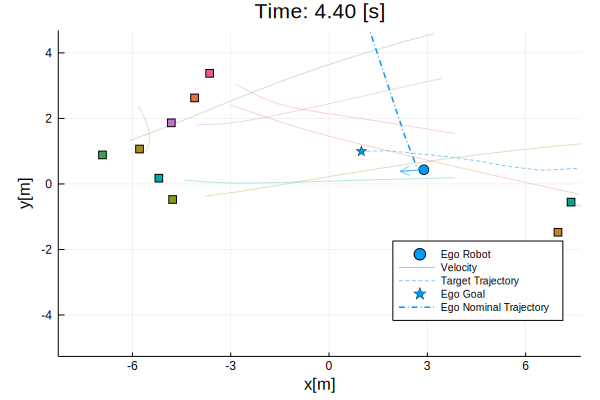

In [28]:
u_nominal_idx = 12;
prediction_dict_clipped = get_clipped_prediction_dict(prediction_dict,
                                              num_samples, u_nominal_idx)
nominal_trajectory = [rpf[u_nominal_idx, t, 1:2] for t = 1:size(rpf, 2)];
plt = visualize!(Dict(), w, target_trajectory, prediction_dict_clipped, num_samples, nominal_trajectory,
         xlim=(-3. + -5.263534, 13. + -5.314636), 
         ylim=(0. + -5.263534, 10. + -5.314636), figsize=(600, 400), 
         legendfontsize=7, legend=:bottomright, markersize=5)

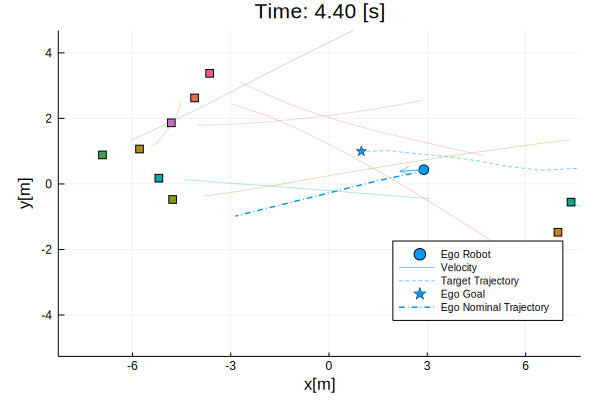

In [29]:
u_nominal_idx = 6;
prediction_dict_clipped = get_clipped_prediction_dict(prediction_dict,
                                              num_samples, u_nominal_idx)
nominal_trajectory = [rpf[u_nominal_idx, t, 1:2] for t = 1:size(rpf, 2)];
plt = visualize!(Dict(), w, target_trajectory, prediction_dict_clipped, num_samples, nominal_trajectory,
         xlim=(-3. + -5.263534, 13. + -5.314636), 
         ylim=(0. + -5.263534, 10. + -5.314636), figsize=(600, 400), 
         legendfontsize=7, legend=:bottomright, markersize=5)